# Preprocessing pipeline

Objective of this notebook is to aggregate seismic processing actions into a neat pipeline. 

* [Dataset](#Dataset)
* [Pipeline](#Pipeline)
* [Conclusion](#Conclusion)
* [Suggestions for improvement](#Suggestions-for-improvement)

## Dataset

For this task we make use of Dataset 1 for processing testing. It contains several raw seismic surveys with large variation in amplitude values.

In [1]:
import os
import sys
sys.path.append('..')
import numpy as np
from matplotlib import pyplot as plt

from seismicpro import FieldIndex, TraceIndex, SeismicDataset
from seismicpro.batchflow import B, D, L, I
from seismicpro.batchflow.models.torch import UNet

from seismicpro.src import merge_segy_files, calculate_sdc_quality

%env CUDA_VISIBLE_DEVICES=7

env: CUDA_VISIBLE_DEVICES=7


In [2]:
path_raw = '../../../data/PREP/1_input_4_PREP_full_pipeln.sgy'
field_index = FieldIndex(name='raw', path=path_raw, extra_headers='all')
field_set = SeismicDataset(field_index)

field_index.head()

,SourceMeasurementUnit,GeophoneGroupNumberRoll1,SweepType,GroupStaticCorrection,SweepTraceTaperLengthEnd,NStackedTraces,TraceIdentifier,ElevationScalar,SecondOfMinute,CDP_X,...,GeophoneGroupNumberLastTraceOrigField,GroupY,WeatheringVelocity,SourceX,InstrumentGainConstant,CDP_Y,OverTravel,TraceIdentificationCode,TRACE_SEQUENCE_FILE,file_id
,,,,,,,,,,,...,,,,,,,,,raw,raw
FieldRecord,,,,,,,,,,,,,,,,,,,,,
8834,0,0,0,0,0,0,7427,-7,35,1500615,...,0,19832998,0,1504760,0,19835984,0,1,1,../../../data/PREP/1_input_4_PREP_full_pipeln.sgy
8834,0,0,0,0,0,0,7427,-7,35,1500690,...,0,19832998,0,1504760,0,19835984,0,1,2,../../../data/PREP/1_input_4_PREP_full_pipeln.sgy
8834,0,0,0,0,0,0,7427,-7,35,1500765,...,0,19832998,0,1504760,0,19835984,0,1,3,../../../data/PREP/1_input_4_PREP_full_pipeln.sgy
8834,0,0,0,0,0,0,7427,-7,35,1500840,...,0,19832998,0,1504760,0,19835984,0,1,4,../../../data/PREP/1_input_4_PREP_full_pipeln.sgy
8834,0,0,0,0,0,0,7427,-7,35,1500915,...,0,19832998,0,1504760,0,19835984,0,1,5,../../../data/PREP/1_input_4_PREP_full_pipeln.sgy


Let's take a look a the raw data before processing it:

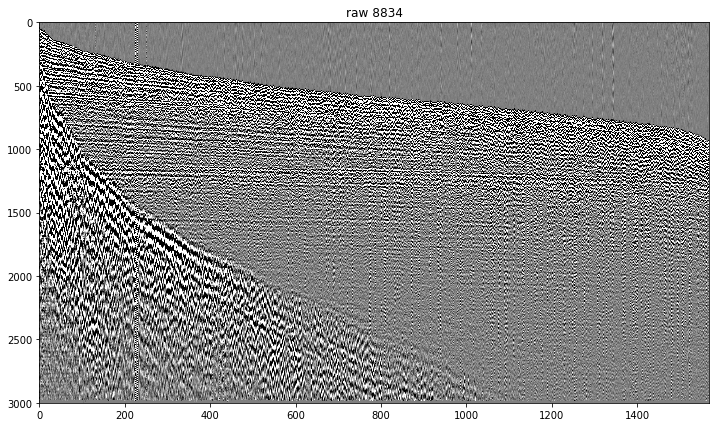

In [3]:
(SeismicDataset(field_index).next_batch(1)
         .load(components='raw', fmt='segy')
         .sort_traces(src='raw', dst='raw', sort_by='offset')
         .seismic_plot('raw', field_index.indices[0], figsize=(12, 7), vmax=0.1, vmin=-0.1, cmap='gray'))

## Preprocessing pipeline

For spherical divergence correction (SDC) we'll use predefined speed values:

In [4]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5]*2250 + [3566]*2800 + [4785.3]*1000)

In this pipeline we preform SDC, remove traces that contain more than 50 consequent zero values, and estimate parameters for quantile normalization. 

Parameters for SDC are calculated via optimization procedure once for the whole dataset in `before` instance of pipeline and saved to `SeismicDataset`'s attribute with `save_to` argument. Parameters for quantile normalization stored in `SeismicDataset` instance's attribute defined by `container_name` and are updated after each batch to be used later.

In [5]:
first_preproc_ppl = (
    field_set.pipeline()
    .init_variable('sdc_params')
    .load(fmt='sgy', components='raw')
    .sort_traces(sort_by='offset', src='raw', dst='raw')
    .correct_spherical_divergence(src='raw', dst='raw', speed=speed, params=D('sdc_params'))
    .drop_zero_traces(src='raw', dst='raw', num_zero=50)
    .find_equalization_params(B(), component='raw', survey_id_col='YearDataRecorded', container_name='equal_params')
    .run_later(batch_size=5, n_epochs=1, shuffle=False, drop_last=False, bar=True)
    )

(first_preproc_ppl.before
                  .find_sdc_params(component='raw', method='SLSQP', speed=speed, loss=calculate_sdc_quality, initial_point=(2, 1), save_to=D('sdc_params')))

Let's run pipeline and calculate all parameters that we need:

In [6]:
first_preproc_ppl.run()

100%|██████████| 6/6 [01:46<00:00, 17.70s/it]


Second pipeline utilizes parameters from the same instance of `SeismicDataset` to process and then save each batch. In `after` instance of pipeline we merge all saved batches to obtain resulting SEG-Y file:

In [7]:
tmp_dump_path = '../../../data/preproc/tmp/'
output_path = '../../../data/preproc/processed/merged.sgy'

second_preproc_ppl = (
    field_set.pipeline()
    .load(fmt='sgy', components='raw')
    .sort_traces(sort_by='offset', src='raw', dst='raw')
    .correct_spherical_divergence(src='raw', dst='raw', speed=speed, params=D('sdc_params'))
    .drop_zero_traces(src='raw', dst='raw', num_zero=50)
    .equalize(src='raw', dst='raw', params=D('equal_params'))
    .dump(path=L(lambda x: os.path.join(tmp_dump_path, str(x) + '.sgy'))(I()),
          src='raw', fmt='segy', split=False)
    .run_later(batch_size=5, n_epochs=1, shuffle=False, drop_last=False, bar=True)
)

(second_preproc_ppl.after
                  .merge_segy_files(output_path=output_path, extra_headers='all', path=os.path.join(tmp_dump_path, '*.sgy')))

Run second pipeline:

In [8]:
second_preproc_ppl.run()

100%|██████████| 6/6 [00:19<00:00,  3.47s/it]


Now we can take a look at the result:

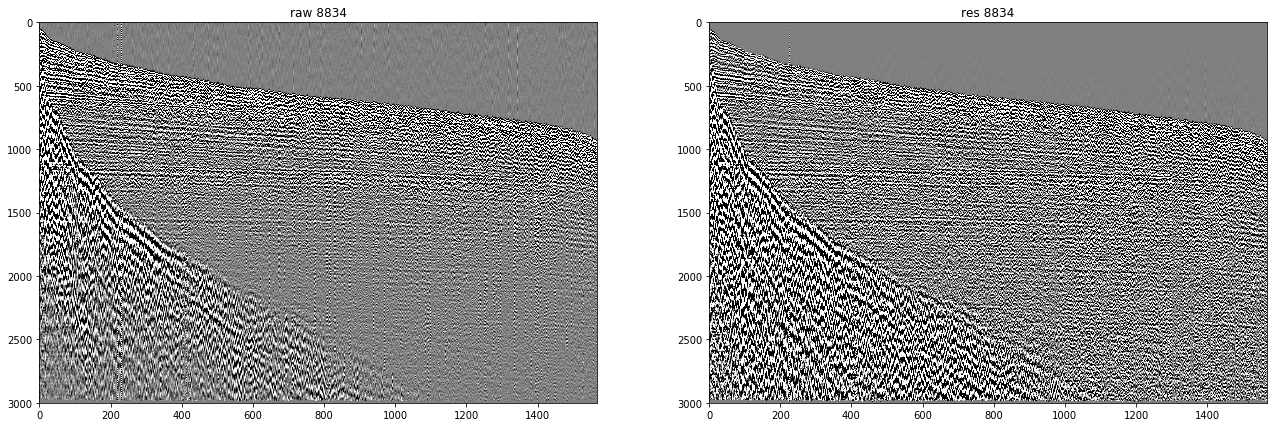

In [9]:
result_index = FieldIndex(name='res', path=output_path).merge(FieldIndex(name='raw', path=path_raw, extra_headers='all'))

(SeismicDataset(result_index).next_batch(1)
         .load(components=('raw', 'res'), fmt='segy')
         .sort_traces(src=('raw', 'res'), dst=('raw', 'res'), sort_by='offset')
         .seismic_plot(('raw', 'res'), field_index.indices[0], figsize=(22, 7), vmax=0.1, vmin=-0.1, cmap='gray'))

## Picking pipeline

We will now use resulting data to perform first break picking. First, create a dataset:

In [10]:
picking_dataset = SeismicDataset(TraceIndex(name='raw', path=output_path))

Then define model config and picking pipeline. Results will be saved to the csv file:

In [11]:
picking_path = 'picking_predictions.csv'

config = {
    'build': False,
    'load/path':  'picking_model.dill',
    'device': 'gpu:0'
}

picking_pipeline = (picking_dataset.p
                      .init_model('static', UNet, 'picking_model', config=config) 
                      .load(components='raw', fmt='segy', tslice=slice(0,1000))
                      .standardize(src='raw', dst='raw')
                      .apply_transform_all(src='raw', dst='raw', func=lambda x: np.stack(x))
                      .add_components(components='predictions')
                      .predict_model('picking_model', B('raw'), fetches='predictions',
                                       save_to=B('predictions', mode='a'))
                      .mask_to_pick(src='predictions', dst='predictions', labels=False)
                      .dump(src='predictions', fmt='picks',path=picking_path, traces='raw', to_samples=True)
                      .run_later(1000, n_epochs=1, drop_last=False, shuffle=False, bar=True))

/usr/local/lib/python3.5/dist-packages/torch/serialization.py:453: SourceChangeWarning: source code of class 'seismicpro.batchflow.models.torch.layers.conv_block.ConvBlock' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


We are ready to run picking:

In [12]:
picking_pipeline.run()

100%|██████████| 87/87 [00:19<00:00,  5.14it/s]


Let's take a look at the results:

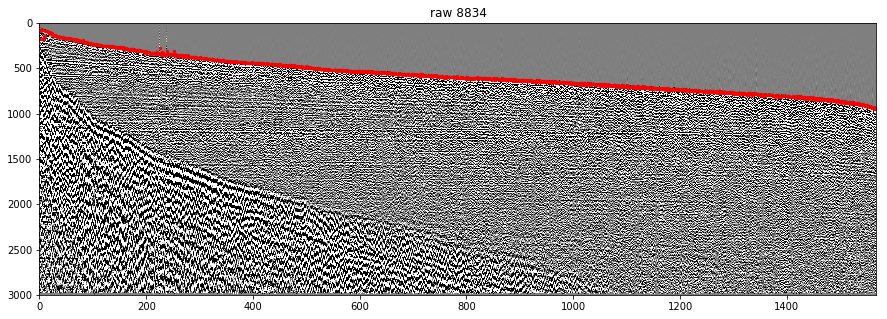

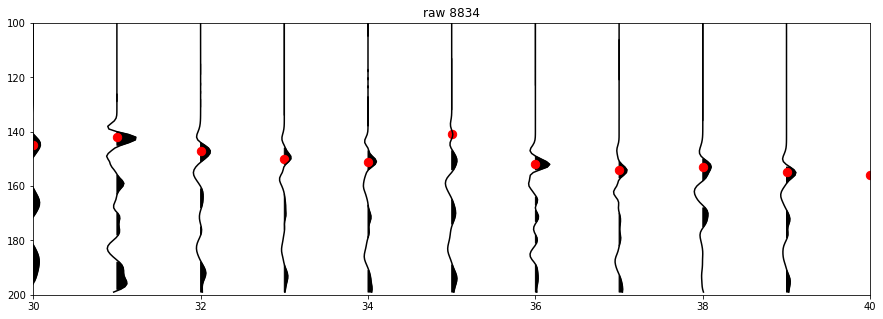

In [13]:
picked_dataset = SeismicDataset(FieldIndex(name='raw', path=output_path, markup_path=picking_path))

cv = 0.1
batch = (picked_dataset.next_batch(batch_size=1)
        .load(components='raw', fmt='segy')
        .load(components='markup', fmt='picks')
        .seismic_plot('raw', picked_dataset.index.indices[0], src_picking='markup', cmap='gray',
                     figsize=(15,5), vmax=cv, vmin=-cv, s=5, scatter_color='r')
        .seismic_plot('raw', picked_dataset.index.indices[0], src_picking='markup', cmap='gray',
                     figsize=(15,5), vmax=cv, vmin=-cv, s=70, scatter_color='r',
                     wiggle=True, xlim=(30,40), ylim=(100,200), std=0.1))

## Conclusion

Current version of notebook contains preprocessing pipeline with three actions: correction of spherical divergence, removal of traces with more than 50 consecuent zeros and equalization of amplitudes. This pipeline produces a new SEGY file with processed data.

Second stage is first-break picking pipeline that takes result of preprocessing pipeline and produces a csv file with labels of first breaks.

#### Time estimates
* Calculation of SDC and normalization parameters: ~ 110 seconds for 30 fields with batch size equal to 5;
* Preprocessing actions and dump: ~ 50 seconds for 30 fields batch size equal to 5;
* Merging SEG-Y: ~ 20 seconds for 6 files;
* Picking: ~ 20 seconds for 30 fields with batch size equal to 1000 traces.

## Suggestions for improvement

The next step in development of pipeline is adding two more actions: correction of inverted traces and attenuation of industrial noise.